# Preprocessing

In [4]:
import os
import tensorflow as tf

# Define paths to training and testing datasets
path = os.getcwd()
TRAIN_PATH = os.path.join(path, 'archive/Train')
TEST_PATH = os.path.join(path, 'archive/Test-A')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224
BATCH_SIZE = 32

data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)


train_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='training',batch_size = BATCH_SIZE,shuffle = True,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='validation',batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = TEST_PATH,batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


In [6]:
import torch, os, numpy as np, random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tensorflow.keras.utils import set_random_seed

# Reproducibility
SEED = 4323
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED); tf.random.set_seed(SEED); set_random_seed(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ImageNet normalization for ResNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(TRAIN_PATH, transform=train_tfms)
test_ds  = datasets.ImageFolder(TEST_PATH,  transform=test_tfms)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_ds.classes)
class_names = train_ds.classes
class_to_idx = train_ds.class_to_idx
print("Classes:", class_names)


Classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


# LSTM

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape

# Get number of classes
num_classes = len(train_gen.class_indices)

# Pure LSTM resnet_model - reshape image to sequence
model = Sequential([
    Reshape((IMAGE_SIZE, IMAGE_SIZE * 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 224, 672)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 224, 256)       │       951,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 224, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,789 (4.60 MB)

 Trainable params: 1,206,789 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 150s 575ms/step - accuracy: 0.6081 - loss: 1.1094 - val_accuracy: 0.6129 - val_loss: 1.0804
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 562ms/step - accuracy: 0.6123 - loss: 1.0947 - val_accuracy: 0.6129 - val_loss: 1.1075
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - accuracy: 0.6123 - loss: 1.0881 - val_accuracy: 0.6129 - val_loss: 1.0833
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 553ms/step - accuracy: 0.6123 - loss: 1.0841 - val_accuracy: 0.6129 - val_loss: 1.0749
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 144s 565ms/step - accuracy: 0.6123 - loss: 1.0871 - val_accuracy: 0.6129 - val_loss: 1.0728
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 145s 567ms/step - accuracy: 0.6123 - loss: 1.0863 - val_accuracy: 0.6129 - val_loss: 1.0741
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 145s 570ms/step - accuracy: 0.6123 - loss: 1.0840 - val_accuracy: 0.6129 - val_loss: 1.0737
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 148s 578ms/step - accuracy: 0.6123 -

In [9]:
# Evaluate on test data
print("\n" + "="*50)
print("EVALUATING ON TEST SET...")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*50)

# Compare all three sets
print("\n" + "="*50)
print("COMPARISON: TRAIN vs VALIDATION vs TEST")
print("="*50)
print(f"Training Accuracy:   {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*50)


EVALUATING ON TEST SET...
136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.6130 - loss: 1.0739

TEST SET RESULTS
Test Accuracy: 0.6130 (61.30%)
Test Loss: 1.0739

COMPARISON: TRAIN vs VALIDATION vs TEST
Training Accuracy:   0.6123 (61.23%)
Validation Accuracy: 0.6129 (61.29%)
Test Accuracy:       0.6130 (61.30%)


In [10]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*50)

136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.6130 - loss: 1.0739

TEST SET EVALUATION
Test Accuracy: 0.6130 (61.30%)
Test Loss: 1.0739


In [11]:
from matplotlib import pyplot as plt

def plot_curves(history, model_name):
    def plot_loss_curves(history, plot):
        plot.plot(history.history['loss'], label='Train Loss')
        plot.plot(history.history['val_loss'], label='Validation Loss')
        plot.set_title(f'{model_name}: Training & Validation Loss')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Mean Squared Error (Loss)')
        plot.legend()
        plot.grid(True)

    def plot_accuracy_curves(history, plot):
        plot.plot(history.history['accuracy'], label='Train Accuracy')
        plot.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plot.set_title(f'{model_name}: Training & Validation Accuracy')
        plot.set_xlabel('Epoch')
        plot.set_ylabel('Accuracy')
        plot.legend()
        plot.grid(True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plot_loss_curves(history, ax1)
    plot_accuracy_curves(history, ax2)
    plt.show()

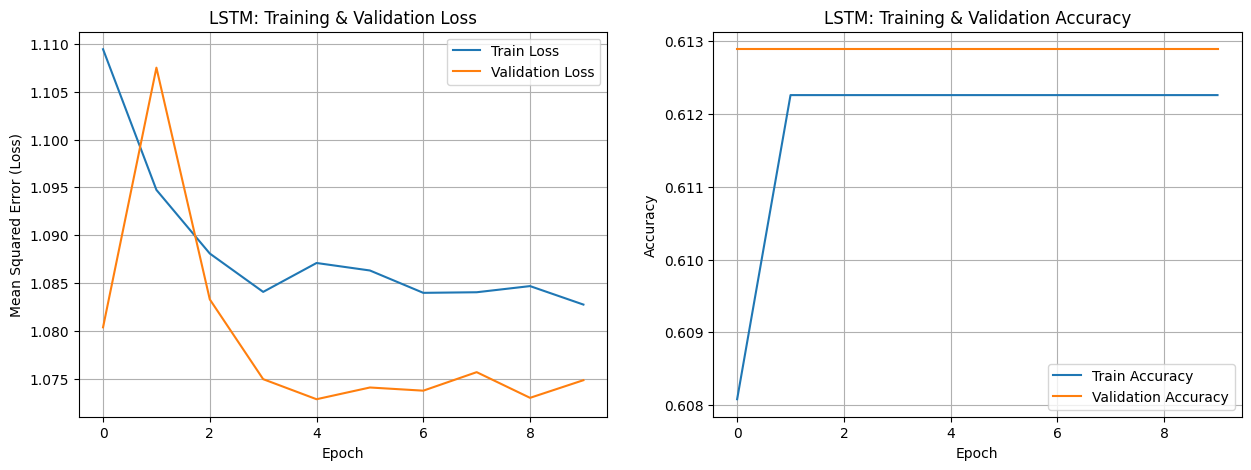

In [12]:
plot_curves(history, "LSTM")

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [14]:

# Get predictions on test set
print("\n" + "="*50)
print("GENERATING PREDICTIONS...")
print("="*50)

test_gen.reset()  # Reset generator to start from beginning
predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Calculate overall metrics
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)
print("\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*50)

# Detailed classification report (per-class metrics)
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Per-Class Metrics)")
print("="*50)
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

import numpy as np

# See which classes the model predicts
unique, counts = np.unique(predicted_classes, return_counts=True)
class_labels = list(test_gen.class_indices.keys())

print("\n" + "="*50)
print("PREDICTION DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique, counts):
    print(f"{class_labels[class_idx]}: {count} predictions ({count/len(predicted_classes)*100:.2f}%)")
print("="*50)

# See true class distribution
unique_true, counts_true = np.unique(true_classes, return_counts=True)
print("\n" + "="*50)
print("TRUE CLASS DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique_true, counts_true):
    print(f"{class_labels[class_idx]}: {count} images ({count/len(true_classes)*100:.2f}%)")
print("="*50)


GENERATING PREDICTIONS...
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step

OVERALL METRICS
Precision: 0.3758 (37.58%)
Recall:    0.6130 (61.30%)
F1-Score:  0.4660 (46.60%)

CLASSIFICATION REPORT (Per-Class Metrics)
              precision    recall  f1-score   support

    Basophil       0.00      0.00      0.00        89
  Eosinophil       0.00      0.00      0.00       322
  Lymphocyte       0.00      0.00      0.00      1034
    Monocyte       0.00      0.00      0.00       234
  Neutrophil       0.61      1.00      0.76      2660

    accuracy                           0.61      4339
   macro avg       0.12      0.20      0.15      4339
weighted avg       0.38      0.61      0.47      4339


PREDICTION DISTRIBUTION
Neutrophil: 4339 predictions (100.00%)

TRUE CLASS DISTRIBUTION
Basophil: 89 images (2.05%)
Eosinophil: 322 images (7.42%)
Lymphocyte: 1034 images (23.83%)
Monocyte: 234 images (5.39%)
Neutrophil: 2660 images (61.30%)


# CNN

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

In [16]:
initial_model_cnn = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
initial_model_cnn.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy', 
    metrics=['accuracy'])
initial_model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,476,549 (196.37 MB)

 Trainable params: 51,476,549 (196.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_cnn = initial_model_cnn.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=valid_gen
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 222s 865ms/step - accuracy: 0.6575 - loss: 1.2492 - val_accuracy: 0.7452 - val_loss: 0.7244
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 212s 830ms/step - accuracy: 0.8101 - loss: 0.5400 - val_accuracy: 0.7772 - val_loss: 0.5894
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 227s 888ms/step - accuracy: 0.8690 - loss: 0.3719 - val_accuracy: 0.7865 - val_loss: 0.5533
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 216s 845ms/step - accuracy: 0.8994 - loss: 0.2853 - val_accuracy: 0.8155 - val_loss: 0.5100
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 212s 831ms/step - accuracy: 0.9177 - loss: 0.2371 - val_accuracy: 0.7988 - val_loss: 0.5595
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 215s 842ms/step - accuracy: 0.9266 - loss: 0.2132 - val_accuracy: 0.8264 - val_loss: 0.4617
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 218s 855ms/step - accuracy: 0.9328 - loss: 0.2002 - val_accuracy: 0.8195 - val_loss: 0.5134
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 220s 861ms/step - accuracy: 0.9353 -

In [19]:
initial_cnn_loss, initial_cnn_accuracy = initial_model_cnn.evaluate(test_gen, verbose=0)
print(f"CNN Test Loss: {initial_cnn_loss:.4f}")
print(f"CNN Test Accuracy: {initial_cnn_accuracy:.4f}")

CNN Test Loss: 0.2797
CNN Test Accuracy: 0.9032


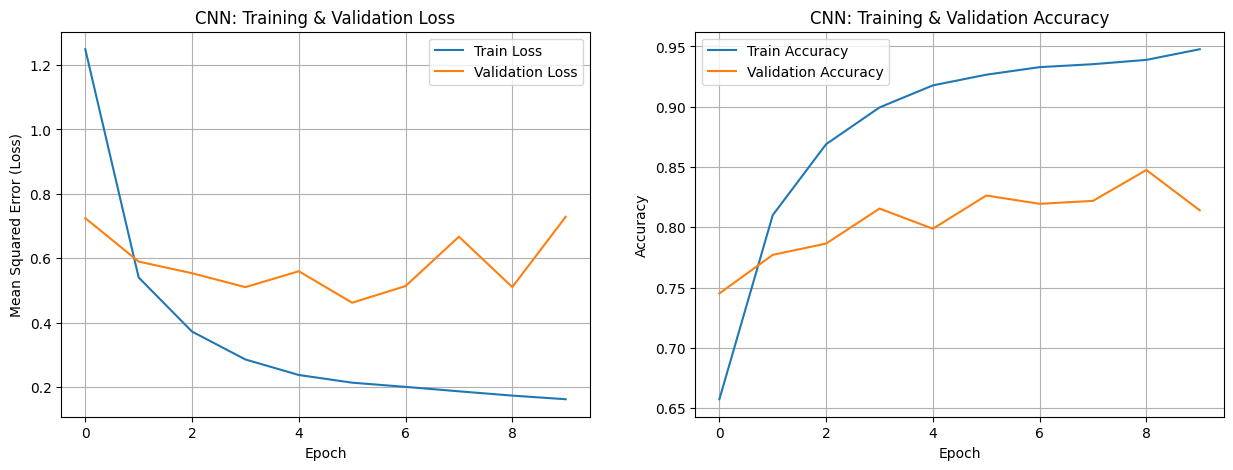

In [20]:
plot_curves(history_cnn, "CNN")

In [21]:

# Get predictions on test set
print("\n" + "="*50)
print("GENERATING PREDICTIONS...")
print("="*50)

test_gen.reset()  # Reset generator to start from beginning
cnn_predictions = initial_model_cnn.predict(test_gen, verbose=1)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Calculate overall metrics
cnn_precision = precision_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
cnn_recall = recall_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
cnn_f1 = f1_score(true_classes, cnn_predicted_classes, average='weighted', zero_division=0)
print("\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Precision: {cnn_precision:.4f} ({cnn_precision*100:.2f}%)")
print(f"Recall:    {cnn_recall:.4f} ({cnn_recall*100:.2f}%)")
print(f"F1-Score:  {cnn_f1:.4f} ({cnn_f1*100:.2f}%)")
print("="*50)

# Detailed classification report (per-class metrics)
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Per-Class Metrics)")
print("="*50)
print(classification_report(true_classes, cnn_predicted_classes, target_names=class_labels, zero_division=0))

# See which classes the model predicts
unique, counts = np.unique(cnn_predicted_classes, return_counts=True)
class_labels = list(test_gen.class_indices.keys())

print("\n" + "="*50)
print("PREDICTION DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique, counts):
    print(f"{class_labels[class_idx]}: {count} predictions ({count/len(cnn_predicted_classes)*100:.2f}%)")
print("="*50)

# See true class distribution
unique_true, counts_true = np.unique(true_classes, return_counts=True)
print("\n" + "="*50)
print("TRUE CLASS DISTRIBUTION")
print("="*50)
for class_idx, count in zip(unique_true, counts_true):
    print(f"{class_labels[class_idx]}: {count} images ({count/len(true_classes)*100:.2f}%)")
print("="*50)


GENERATING PREDICTIONS...
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step

OVERALL METRICS
Precision: 0.9196 (91.96%)
Recall:    0.9032 (90.32%)
F1-Score:  0.9050 (90.50%)

CLASSIFICATION REPORT (Per-Class Metrics)
              precision    recall  f1-score   support

    Basophil       0.90      0.99      0.94        89
  Eosinophil       0.58      0.82      0.68       322
  Lymphocyte       0.86      0.99      0.92      1034
    Monocyte       0.93      0.54      0.69       234
  Neutrophil       0.98      0.91      0.95      2660

    accuracy                           0.90      4339
   macro avg       0.85      0.85      0.83      4339
weighted avg       0.92      0.90      0.91      4339


PREDICTION DISTRIBUTION
Basophil: 98 predictions (2.26%)
Eosinophil: 460 predictions (10.60%)
Lymphocyte: 1188 predictions (27.38%)
Monocyte: 136 predictions (3.13%)
Neutrophil: 2457 predictions (56.63%)

TRUE CLASS DISTRIBUTION
Basophil: 89 images (2.05%)
Eosinophil: 322 images (7.42%)
Lymphocyte

# ResNet

In [22]:
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load pretrained ResNet18
resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Option A: fine-tune last block + FC (good tradeoff)
for name, p in resnet_model.named_parameters():
    p.requires_grad = False
for name, p in resnet_model.layer4.named_parameters():
    p.requires_grad = True
for name, p in resnet_model.fc.named_parameters():
    p.requires_grad = True

# Replace FC
in_feats = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_feats, num_classes)
resnet_model = resnet_model.to(device)

# Loss/optimizer/scheduler
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=3e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

def run_epoch(resnet_model, loader, train=True):
    resnet_model.train(train)
    total_loss, total_correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = resnet_model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
    avg_loss = total_loss / total
    acc = total_correct / total
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_labels)

EPOCHS = 10
best_acc = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(resnet_model, train_loader, train=True)
    te_loss, te_acc, te_preds, te_labels = run_epoch(resnet_model, test_loader, train=False)
    scheduler.step(te_acc)
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(resnet_model.state_dict(), "resnet18_best.pt")
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

print("Best test acc:", best_acc)
print(classification_report(te_labels, te_preds, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(te_labels, te_preds))


/Users/eggchavez/Code/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train loss 0.1741 acc 0.9415 | test loss 0.1524 acc 0.9532
Epoch 02 | train loss 0.0761 acc 0.9746 | test loss 0.1290 acc 0.9599
Epoch 03 | train loss 0.0563 acc 0.9819 | test loss 0.1091 acc 0.9664
Epoch 04 | train loss 0.0463 acc 0.9848 | test loss 0.1842 acc 0.9509
Epoch 05 | train loss 0.0419 acc 0.9856 | test loss 0.2060 acc 0.9440
Epoch 06 | train loss 0.0340 acc 0.9889 | test loss 0.1673 acc 0.9592
Epoch 07 | train loss 0.0219 acc 0.9931 | test loss 0.1042 acc 0.9703
Epoch 08 | train loss 0.0175 acc 0.9937 | test loss 0.0785 acc 0.9774
Epoch 09 | train loss 0.0169 acc 0.9936 | test loss 0.1450 acc 0.9594
Epoch 10 | train loss 0.0135 acc 0.9960 | test loss 0.0820 acc 0.9756
Best test acc: 0.9774141507259737
              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.83      0.98      0.90       322
  Lymphocyte       0.99      0.98      0.98      1034
    Monocyte       0.95      0.91      0.93      

In [31]:
resnet_model.eval()
y_true = []
y_pred = []

for images, labels in test_loader:
    images = images.to(device)
    outputs = resnet_model(images)
    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

resnet_precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
resnet_recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
resnet_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print(f'Precision: {resnet_precision:.4f} ({resnet_precision*100:.2f}%)')
print(f'Recall: {resnet_recall:.4f} ({resnet_recall*100:.2f}%)')
print(f'F1 Score: {resnet_f1:.4f} ({resnet_f1*100:.2f}%)')

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Precision: 0.9778 (97.78%)
Recall: 0.9756 (97.56%)
F1 Score: 0.9761 (97.61%)


# SVM

In [24]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Build a feature extractor = everything up to avgpool
feat_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feat_model.fc = nn.Identity()  # so forward returns 512 features
feat_model = feat_model.to(device)
feat_model.eval()  # full freeze
for p in feat_model.parameters():
    p.requires_grad = False

def extract_features(dloader):
    feats, labels = [], []
    with torch.no_grad():
        for x, y in dloader:
            x = x.to(device)
            f = feat_model(x)             # [B, 512]
            f = f.view(f.size(0), -1)     # flatten
            feats.append(f.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)

X_tr, y_tr = extract_features(train_loader)
X_te, y_te = extract_features(test_loader)

# SVM pipeline (scale -> SVC). RBF usually strong; try linear as ablation.
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=2.0, gamma="scale", class_weight=None, probability=False, random_state=SEED))
])
svm_clf.fit(X_tr, y_tr)

svm_preds = svm_clf.predict(X_te)
print("SVM Classification Report:")
print(classification_report(y_te, svm_preds, target_names=class_names))
print("SVM Confusion Matrix:\n", confusion_matrix(y_te, svm_preds))


SVM Classification Report:
              precision    recall  f1-score   support

    Basophil       1.00      0.65      0.79        89
  Eosinophil       0.53      0.62      0.57       322
  Lymphocyte       0.86      0.84      0.85      1034
    Monocyte       0.76      0.59      0.66       234
  Neutrophil       0.90      0.91      0.91      2660

    accuracy                           0.85      4339
   macro avg       0.81      0.72      0.76      4339
weighted avg       0.85      0.85      0.85      4339

SVM Confusion Matrix:
 [[  58    2    5    3   21]
 [   0  200   35   10   77]
 [   0   30  867   16  121]
 [   0   16   20  137   61]
 [   0  128   84   15 2433]]


In [35]:
feat_model.eval()
y_true = []
y_pred = []

for images, labels in test_loader:
    images = images.to(device)
    feats = feat_model(images)
    feats = feats.view(feats.size(0), -1).cpu().numpy()
    preds = svm_clf.predict(feats)
    y_pred.extend(preds)
    y_true.extend(labels.cpu().numpy())

svm_precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
svm_recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
svm_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print(f'Precision: {svm_precision:.4f} ({svm_precision*100:.2f}%)')
print(f'Recall: {svm_recall:.4f} ({svm_recall*100:.2f}%)')
print(f'F1 Score: {svm_f1:.4f} ({svm_f1*100:.2f}%)')

/Users/eggchavez/Code/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Precision: 0.8549 (85.49%)
Recall: 0.8516 (85.16%)
F1 Score: 0.8516 (85.16%)


# Final Comparisons

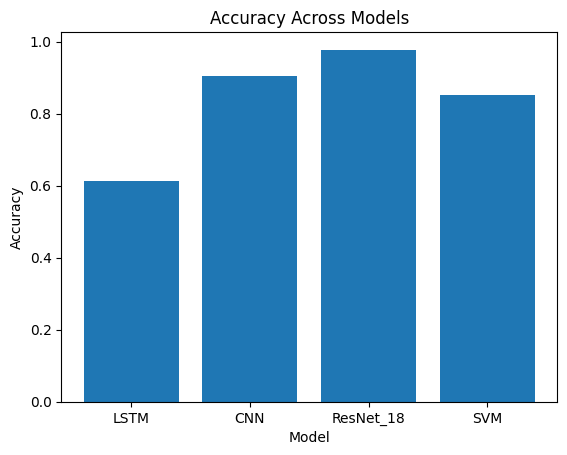

In [37]:
plt.bar(["LSTM", "CNN", "ResNet_18", "SVM"], [test_accuracy, initial_cnn_accuracy, best_acc, svm_clf.score(X_te, y_te)])
plt.title("Accuracy Across Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_99765/3813151153.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_99765/3813151153.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/var/folders/15/5_06gwdn0rs16jky7k2nfmvr0000gn/T/ipykernel_99765/3813151153.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


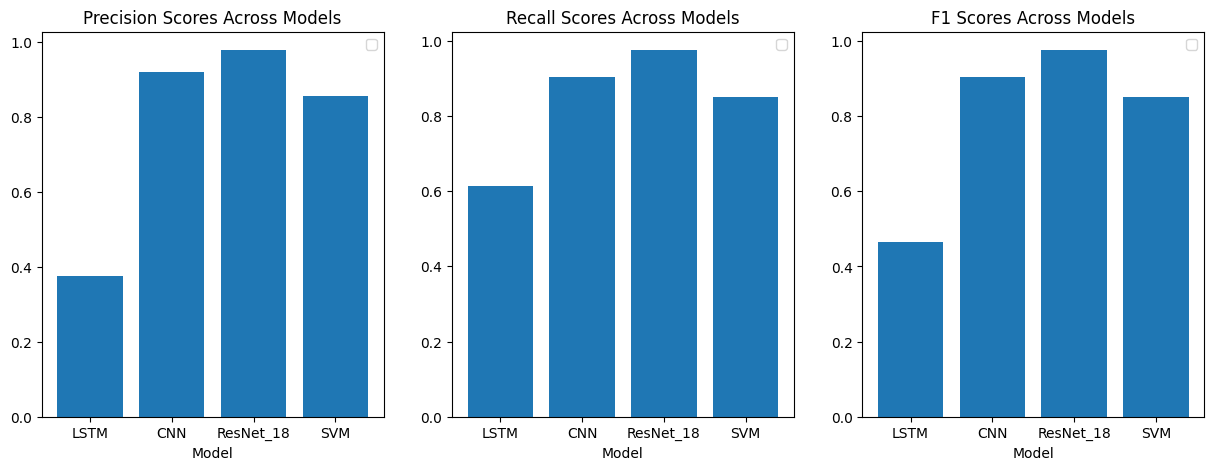

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.bar(["LSTM", "CNN", "ResNet_18", "SVM"], [precision, cnn_precision, resnet_precision, svm_precision])
ax1.set_title("Precision Scores Across Models")
ax1.set_xlabel("Model")
ax1.legend()

ax2.bar(["LSTM", "CNN", "ResNet_18", "SVM"], [recall, cnn_recall, resnet_recall, svm_recall])
ax2.set_title("Recall Scores Across Models")
ax2.set_xlabel("Model")
ax2.legend()

ax3.bar(["LSTM", "CNN", "ResNet_18", "SVM"], [f1, cnn_f1, resnet_f1, svm_f1])
ax3.set_title("F1 Scores Across Models")
ax3.set_xlabel("Model")
ax3.legend()

plt.show()